In [14]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import gcm_filtering
import os
import xrft

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

importlib.reload(gcm_filtering)
from gcm_filtering import filter_inputs
from gcm_filtering import filter_inputs_dataset

# Functions to generate coupled dataset

In [3]:
def load_and_combine_cm26(
    filesystem: gcsfs.GCSFileSystem, inline_array=False
) -> xr.Dataset:
    """Loads, combines, and preprocesses CM2.6 data
    Steps:
    - Interpolate ocean velocities on ocean tracer points (with xgcm)
    - Regrid atmospheric variables to ocean tracer grid (with xesmf)
    - Match time and merge datasets
    - Adjust units for aerobulk input
    - Calculate relative wind components
    """
    kwargs = dict(
        consolidated=True, use_cftime=True, inline_array=inline_array, engine="zarr"
    )
    print("Load Data")
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/surface")
    ds_ocean = xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean_boundary")
    xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)

    # xarray says not to do this
    # ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr")
    ds_atmos = xr.open_dataset(mapper, chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
    ds_oc_grid = xr.open_dataset(mapper, chunks={}, **kwargs)
    # ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

    print("Align in time")
    # cut to same time
    all_dims = set(list(ds_ocean.dims) + list(ds_atmos.dims))
    ds_ocean, ds_atmos = xr.align(
        ds_ocean,
        ds_atmos,
        join="inner",
        exclude=(di for di in all_dims if di != "time"),
    )

    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    from xgcm import Grid

    # add xgcm comodo attrs
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)
    # fill missing values with 0, then interpolate.
    sst_wet_mask = ~np.isnan(ds_ocean["surface_temp"])
    # TODO: Maybe stencil out the nans from SST? This is done again in aerobulk-python
    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    # FIXME: All of these additional operations (filling/masking) add lot more tasks...

    print("Regrid Atmospheric Data")
    # Start regridding the atmosphere onto the ocean grid
    # Load precalculated regridder weights from group bucket
    # TODO: Maybe this should be an input argument?
    path = "gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr"  # noqa: E501
    mapper = filesystem.get_mapper(path)
    ds_regridder = xr.open_zarr(mapper).load()
    regridder = xe.Regridder(
        ds_atmos.olr.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),  # this is the same dumb problem I keep having with
        ds_ocean.surface_temp.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),
        "bilinear",
        weights=ds_regridder,
        periodic=True,
    )
    ds_atmos_regridded = regridder(
        ds_atmos[["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind", "rh_ref"]]
    )  # We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'

    ## combine into merged dataset
    ds_merged = xr.merge(
        [
            ds_atmos_regridded,
            ds_ocean[["surface_temp", "u_ocean", "v_ocean"]],
        ]
    )
    print("Modify units")
    # ds_merged = ds_merged.transpose(
    #     'xt_ocean', 'yt_ocean', 'time'
    # )
    # fix units for aerobulk
    ds_merged["surface_temp"] = ds_merged["surface_temp"] + 273.15
    ds_merged["slp"] = ds_merged["slp"] * 100  # check this

    print("Mask nans")
    # atmos missing values are filled with 0s, which causes issues with the filtering
    # Ideally this should be masked before the regridding, but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged['surface_temp'].isel(time=0).reset_coords(drop=True))
    for mask_var in ['slp', 't_ref', 'q_ref', 'v_ref', 'u_ref', 'wind', 'rh_ref']:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)
    
    
    # also apply this mask to certain coordinates from the grid dataset (for now only tracer_area since that 
    for mask_coord in ['area_t']:
        ds_merged.coords[mask_coord] = ds_oc_grid[mask_coord].where(mask,0.0).astype(np.float64)
    # The casting to float64 is needed to avoid that weird bug where the manual global weighted ave
    # is not close to the xarray weighted mean (I was not able to reproduce this with an example)
    
    # Ideally this should be masked before the regridding,
    # but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged["surface_temp"])
    for mask_var in ["slp", "t_ref", "q_ref"]:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)

    # Calculate relative wind
    print("Calculate relative wind")
    ds_merged["u_relative"] = ds_merged["u_ref"] - ds_merged["u_ocean"]
    ds_merged["v_relative"] = ds_merged["v_ref"] - ds_merged["v_ocean"]

    return ds_merged

def preprocess_data():
    
    warnings.filterwarnings("ignore")
    
    # Loading ocean data
    kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
    print("Load Data")
    ocean_path = "gs://cmip6/GFDL_CM2_6/control/surface"
    ds_ocean = xr.open_dataset(fs.get_mapper(ocean_path), chunks={"time": 3}, **kwargs)
    ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
    ds_ocean_boundary = xr.open_dataset(fs.get_mapper(ocean_boundary_path), chunks={"time": 3}, **kwargs)
    grid_path = "gs://cmip6/GFDL_CM2_6/grid"
    ds_ocean_grid = xr.open_dataset(fs.get_mapper(grid_path), chunks={}, **kwargs)
    
    # combine all dataset on the ocean grid together
    ds_ocean = xr.merge([ds_ocean_grid, ds_ocean, ds_ocean_boundary], compat='override')
    
    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)

    # fill missing values with 0, then interpolate.
    tracer_ref = ds_ocean["surface_temp"]
    sst_wet_mask = ~np.isnan(tracer_ref)

    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), tracer_ref
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), tracer_ref
    ).where(sst_wet_mask)

    # Loading atmos data
    atmos_path = "gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr"
    ds_atmos = xr.open_dataset(fs.get_mapper(atmos_path), chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    # rename the atmos data coordinates only to CESM conventions
    ds_atmos = ds_atmos.rename({'grid_xt':'lon', 'grid_yt':'lat'})

    print("Modify units")
    ds_ocean["surface_temp"] = ds_ocean["surface_temp"] + 273.15
    ds_atmos["slp"] = ds_atmos["slp"] * 100  # TODO: Double check this

    # Merge atmos and ocean datasets
    ds_merged  = load_and_combine_cm26(fs, inline_array=True)
    
    return ds_merged

# Generate coupled dataset

1. load_and_combine_cm26()  
   a. Load data: Load ocean surface, ocean boundary, atmosphere, and grid datasets  
   b. Time alignment: Align the ocean and atmosphere datasets along their common time dimension (xr.align) to ensure synchronized time steps  
   c. Interpolate ocean data: Align ocean variables onto t-cell grid  
   d. Regrid atmospheric data onto ocean grid  
   e. Combine interpolated ocean fields and regridded atmospheric fields into one dataset  
   f. Adjust units: Convert ocean surface temperature from °C to K; Convert SLP from hPa to Pa  
   g. Apply masking: Mask atmospheric fields where surface_temp is NaN to avoid invalid values  
   h. Compute relative velocity between atmosphere and ocean  
2. preprocess_data()  
   a. Load ocean datasets: Load ocean surface, boundary, and grid datasets + Merge all ocean-related data into one dataset  
   b. Interpolate ocean data: Align ocean variables onto t-cell grid  
   c. Load atmospheric data  
   d. Adjust units: Convert ocean surface temperature from °C to K; Convert SLP from hPa to Pa  
   e. Invoke load_and_combine_cm26(): This does the heavy lifting: time-align, regrid, interpolate, merge, mask, and compute variables  

There is a lot of overlap here -- I made these functions over a year ago, when I was a much worse coder. At that time, I simply wanted to make sure the output was correct. I haven't looked at these functions since then -- but it is very apparent that these functions could be cleaned up.  
Particularly, Steps a, b, c, f in load_and_combine_cm26() are duplicated in preprocess_data() in steps a, b, c, d. 

In [11]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Functions to filter dataset

In [ ]:
def filter_inputs(
    da: xr.DataArray,
    wet_mask: xr.DataArray,
    dims: list,
    filter_scale: int,
    filter_type: str = "taper",
) -> xr.DataArray:
    """filters input using gcm-filters"""
    if filter_type == "gaussian":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "taper":
        # transition_width = np.pi/2
        transition_width = np.pi
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            transition_width=transition_width,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "tripolar_pop":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
            grid_vars={"area":da.TAREA,"wet_mask": wet_mask},
        )

    else:
        raise ValueError(
            f"`filter_type` needs to be `gaussian` or `taper', got {filter_type}"
        )
    out = input_filter.apply(da, dims=dims)
    out.attrs["filter_scale"] = filter_scale
    out.attrs["filter_type"] = filter_type
    return out

def filter_inputs_dataset(
    ds: xr.Dataset,
    dims: list,
    filter_scale: int,
    timedim: str = "time",
    filter_type: str = "gaussian", #taper
) -> xr.Dataset:
    """Wrapper that filters a whole dataset, generating a wet_mask from
    the nanmask of the first timestep (if time is present)."""
    ds_out = xr.Dataset()

    # create a wet mask that only allows values which are 'wet' in all variables

    wet_masks = []
    for var in ds.data_vars:
        da = ds[var]
        if timedim in da.dims:
            mask_da = da.isel({timedim: 0})
        else:
            mask_da = da
        wet_masks.append((~np.isnan(mask_da)))

    combined_wet_mask = xr.concat(wet_masks, dim="var").all("var").astype(int)

    for var in ds.data_vars:
        ds_out[var] = filter_inputs(
            ds[var], combined_wet_mask, dims, filter_scale, filter_type=filter_type
        )

    ds_out.attrs["filter_scale"] = filter_scale
    ds_out.attrs["filter_type"] = filter_type
    return ds_out

# Filter dataset

1. filter_inputs()  
   a. Choose the filter type (gaussian, taper, or tripolar_pop)  
   b. Set up the gcm_filters.Filter object, which contains  
       --- (1) filter_scale: length scale over which to smooth (in grid units)  
       --- (2) dx_min: minimum grid spacing (here set to 1)  
       --- (3) grid_vars: metadata like _wet_mask_ or _area_ to indicate ocean regions  
   c. Apply the filter along specified dimensions  
   d. Add filter_scale and filter_type metadata onto output  
   e. Return filtered DataArray  
3. filter_inputs_dataset()  
   a. Initialize dataset  
   b. Create a wet_mask that only allows values that are 'wet' in all variables  
   c. Call filtered_inputs() to individually filter eavh variable  
   d. Add filter info to Dataset attributes  
   e. Return the filtered dataset  

In [8]:
ds_in = ds_merged.isel(time=0)

In [9]:
print("Filtering model")
ds_out_50 = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_out_50

Filtering model


<xarray.Dataset> Size: 933MB
Dimensions:       (xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
    time          object 8B 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    rh_ref        (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

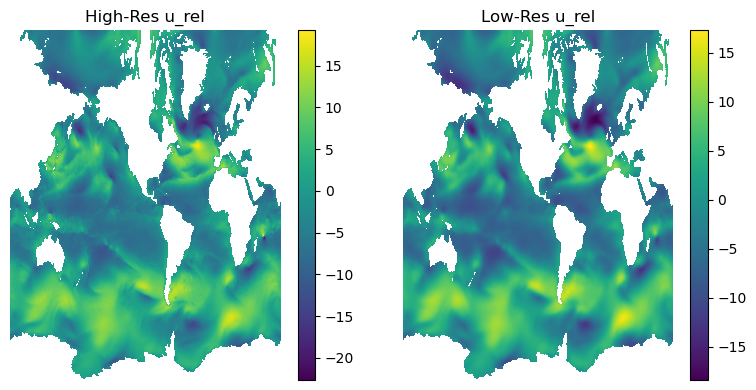

In [10]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_in.u_relative)
axes[0].set_title("High-Res u_rel")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_out_50.u_relative)
axes[1].set_title("Low-Res u_rel")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

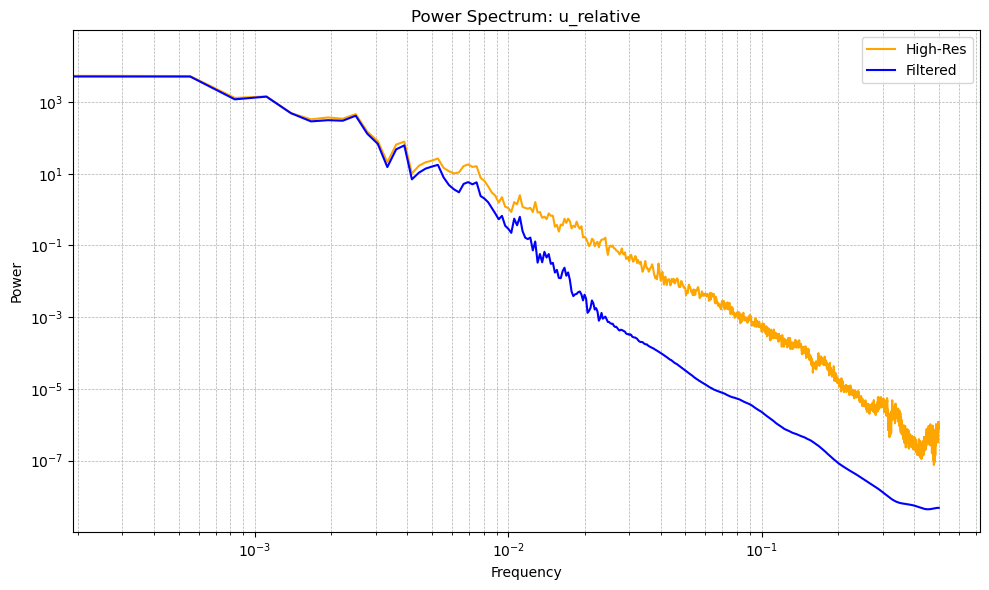

In [15]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(ds_merged.u_relative.shape[-2]),
    'xt_ocean': range(ds_merged.u_relative.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
sample_LR = xr.DataArray(ds_out_50.u_relative, dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_LR = xrft.power_spectrum(sample_LR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

sample_HR = xr.DataArray(ds_in.u_relative, dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_HR = xrft.power_spectrum(sample_HR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='High-Res', color='orange')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='Filtered', color='blue')

# Configure plot
plt.title("Power Spectrum: u_relative")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
